<a href="https://colab.research.google.com/github/PAGIDIPALARAGHU/Data-science/blob/main/SREE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7  as PretrainedModel, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from glob import glob

In [4]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/download?datasetVersionNumber=1')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pagidipalaraghu
Your Kaggle Key: ··········


100%|██████████| 1.76G/1.76G [01:21<00:00, 23.3MB/s]


In [5]:
main_dir='/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
colon_dir='/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'


In [6]:
images_data=[]
folders=os.listdir(main_dir)
print(folders)


['lung_n', 'colon_n', 'lung_scc', '.ipynb_checkpoints', 'colon_aca', 'lung_aca']


In [7]:
path= colon_dir +"/"+ 'colon_aca'
print(path)

/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets/colon_aca


In [8]:
import random
from matplotlib.image import imread
# for i in range(1,26):
#     plt.subplot(5,5,i)
#     random_img_path = colon_dir +'/'+ random(image_data)
#     rand_img= imread(random_img_path)
#     plt.imshow(image.load_img(rand_img))
#     plt.grid(b=None)
#     plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
#     plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [9]:
data_dir = '/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'

# 80-20 Split
data = ImageDataGenerator(validation_split = 0.2)

BATCH_SIZE = 128

# 224 x 224 -- The minimum for EfficientNetB7, you can go as high as 600 x 600
X = Y = 224

training = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

validation = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 20000 images belonging to 6 classes.
Found 5000 images belonging to 6 classes.


In [10]:
ptm = PretrainedModel(
    input_shape=(X, Y, 3),
    weights='imagenet',
    include_top=False)

ptm.trainable = False

K = len(folders)

x = GlobalAveragePooling2D()(ptm.output)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)

y = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=y)

258076736/258076736 [==============================] - 12s 0us/step


In [11]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    training,
    validation_data=validation,
    epochs=5,
    callbacks=[early_stopping])

Epoch 1/5
157/157 [==============================] - 329s 2s/step - loss: 0.5868 - accuracy: 0.7812 - val_loss: 0.1819 - val_accuracy: 0.9290
Epoch 2/5
157/157 [==============================] - 293s 2s/step - loss: 0.1818 - accuracy: 0.9348 - val_loss: 0.1078 - val_accuracy: 0.9636
Epoch 3/5
157/157 [==============================] - 293s 2s/step - loss: 0.1123 - accuracy: 0.9595 - val_loss: 0.0832 - val_accuracy: 0.9718
Epoch 4/5
157/157 [==============================] - 292s 2s/step - loss: 0.1021 - accuracy: 0.9603 - val_loss: 0.0985 - val_accuracy: 0.9620
Epoch 5/5
157/157 [==============================] - 293s 2s/step - loss: 0.0763 - accuracy: 0.9722 - val_loss: 0.0520 - val_accuracy: 0.9808


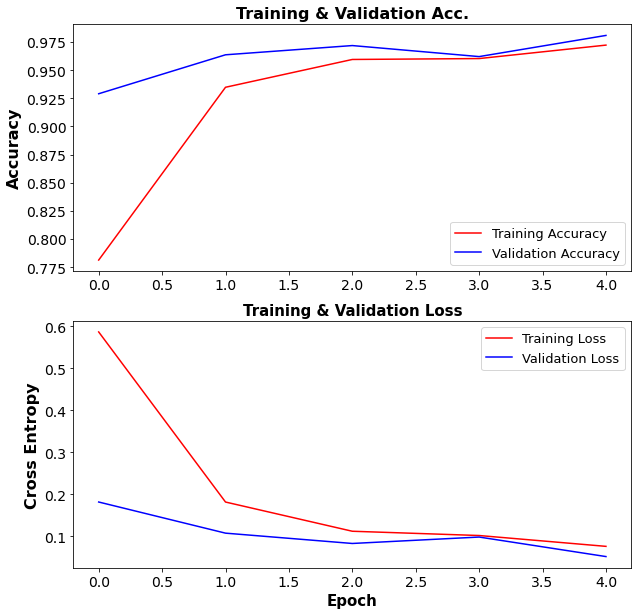

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [15]:
from sklearn.metrics import classification_report

Y_pred = model.predict(validation)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(validation.classes, y_pred))

40/40 [==============================] - 63s 1s/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1000
           2       1.00      1.00      1.00      1000
           3       0.96      0.95      0.95      1000
           4       1.00      1.00      1.00      1000
           5       0.95      0.96      0.96      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



Normalized confusion matrix


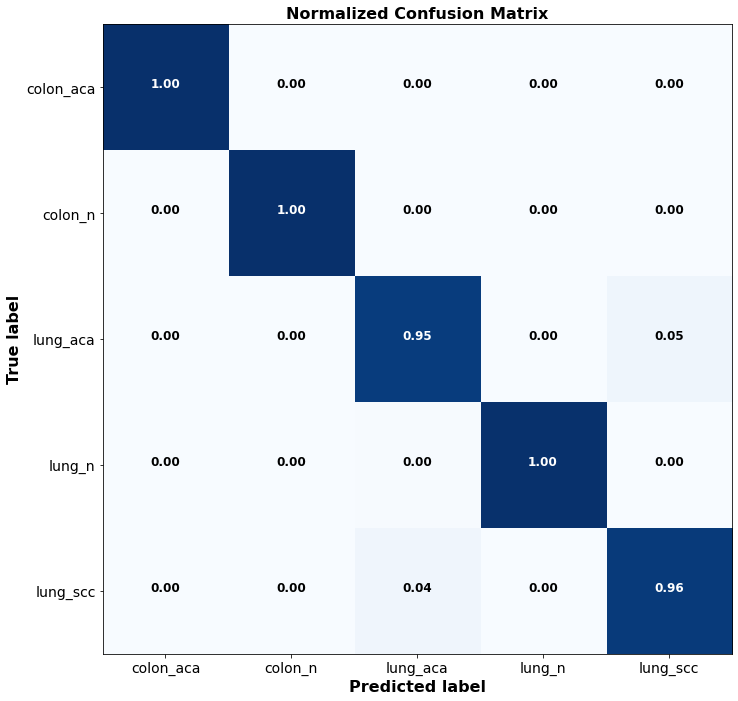

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# Compute confusion matrix
cnf_matrix = confusion_matrix(validation.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()